In [47]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [48]:
import os
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm

IMG_SIZE = 50
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [49]:
class CatsDogsDataset(Dataset):
    def __init__(self, data_paths):
        self.data_paths = data_paths
        self.transform = transforms.Compose([
                            transforms.Grayscale(),
                            transforms.Resize((IMG_SIZE, IMG_SIZE)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,))
                        ])
        self._list_classes = ['cats', 'dogs']
        self._num_classes = len(self._list_classes)
        self._get_images = self.image_list()
        
        self.print_summary()

    def image_list(self):
        all_img = []
        for label in self._list_classes:
            path = os.path.join(self.data_paths, label)
            for f in os.listdir(path):
                files = os.path.join(path, f)
                all_img.append([files, label])
        return all_img

    def get_list(self):
        files = []
        for f in os.listdir(self.data_paths):
            files.append(f)
        return files

    def print_summary(self):
        print(f'Number of classes: {self._num_classes}')
        print(f'List of classes: {self._list_classes}')
        print(f'Total images: {self.__len__()}')
        
    def __len__(self):
        return len(self._get_images)

    def __getitem__(self, idx):
            image = Image.open(self._get_images[idx][0])
            if self.transform:
                image = self.transform(image)
            label = self._list_classes.index(self._get_images[idx][1])
            return image, label

In [50]:
image_paths = os.path.join('data', 'training_set')

training_data = CatsDogsDataset(image_paths)
train_dl = DataLoader(training_data, batch_size=32, shuffle=True)

image_paths = os.path.join('data', 'test_set')

test_data = CatsDogsDataset(image_paths)
test_dl = DataLoader(test_data, batch_size=32, shuffle=True)

Number of classes: 2
List of classes: ['cats', 'dogs']
Total images: 8005
Number of classes: 2
List of classes: ['cats', 'dogs']
Total images: 2023


torch.Size([1, 50, 50]) tensor(1)


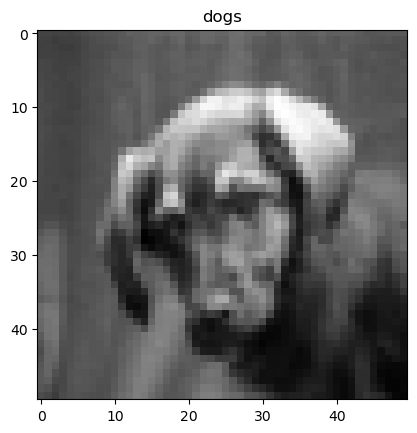

In [51]:
images, labels = next(iter(train_dl))
print(images[0].shape, labels[0])
plt.imshow(images[0].permute(1,2,0), cmap='gray')
plt.title(training_data._list_classes[labels[0]])
plt.show()

torch.Size([1, 50, 50]) tensor(1)


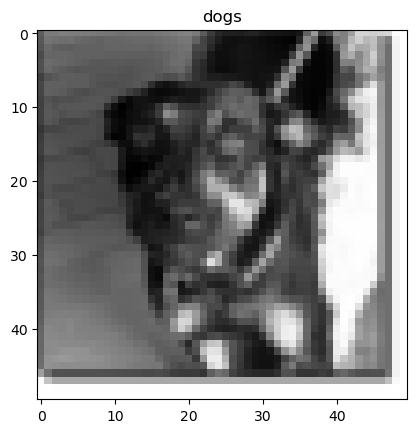

In [52]:
images, labels = next(iter(test_dl))
print(images[0].shape, labels[0])
plt.imshow(images[0].permute(1,2,0), cmap='gray')
plt.title(test_data._list_classes[labels[0]])
plt.show()

In [53]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self._flatten_size = None    # 64x12x12
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        x = torch.randn(IMG_SIZE, IMG_SIZE).view(-1, 1, IMG_SIZE, IMG_SIZE)
        self.forward(x)
        
        self.fc1 = nn.Linear(self._flatten_size , 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, (2, 2))
        
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, (2, 2))
        
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, (2, 2))
        # print(x.shape)

        if self._flatten_size == None:
            self._flatten_size = torch.flatten(x).shape[0]
            return

        x = x.view(-1, self._flatten_size)

        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.softmax(self.fc3(x), dim=1)
        
        return x

In [54]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
model, optimizer, loss_fn

(ConvNet(
   (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
   (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
   (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
   (fc1): Linear(in_features=256, out_features=512, bias=True)
   (fc2): Linear(in_features=512, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=2, bias=True)
 ),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 CrossEntropyLoss())

In [55]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4)

In [59]:
def train(model):
    epochs = 5
    dl = train_dl
    dataset_size = len(dl)
    entries = len(training_data)
    print(f'Entries: {entries}')
    
    for epoch in range(epochs):
        print(f'Epoch: {epoch + 1}')
        running_loss = 0.0
        
        for inputs, labels in tqdm(dl):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
    
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        print(f'Running loss: {running_loss/entries:0.6f}')

train(model)

Entries: 8005
Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:37<00:00,  6.74it/s]


Running loss: 0.560971
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:36<00:00,  6.93it/s]


Running loss: 0.543954
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:36<00:00,  6.79it/s]


Running loss: 0.524485
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:37<00:00,  6.72it/s]


Running loss: 0.509936
Epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:37<00:00,  6.73it/s]

Running loss: 0.488688


In [61]:
def test(model):
    correct = 0
    dl = test_dl
    dataset_size = len(dl)
    entries = len(test_data)
    
    print(f'Entries: {entries}')
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dl):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model_output = model(inputs)
            _, prediction = torch.max(model_output.data, 1)
            correct = torch.sum(prediction == labels.data)

            running_corrects += correct
        print(f'Accuracy: {running_corrects/entries}')

test(model)
        

Entries: 2023


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:06<00:00,  9.76it/s]

Accuracy: 0.7187345027923584


torch.Size([50, 50]) 0


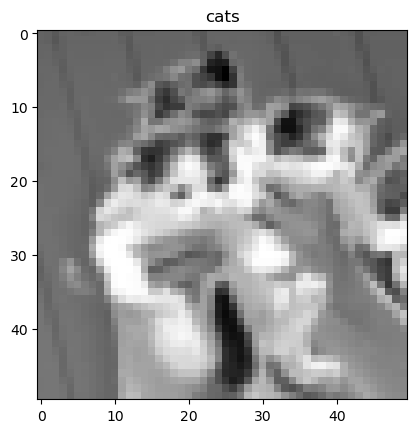

torch.Size([50, 50]) 0


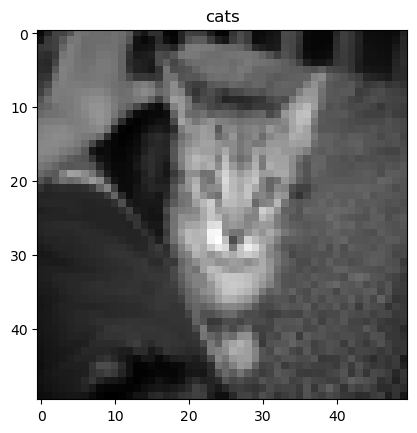

torch.Size([50, 50]) 1


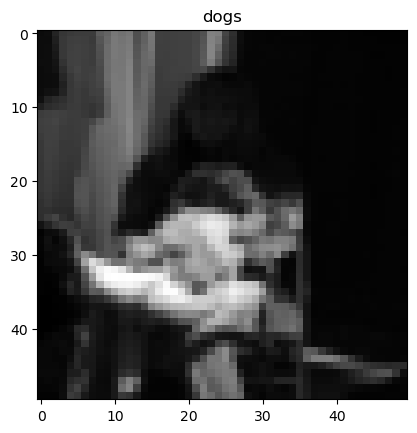

torch.Size([50, 50]) 0


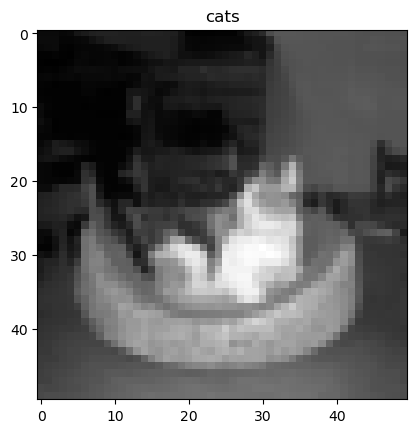

torch.Size([50, 50]) 1


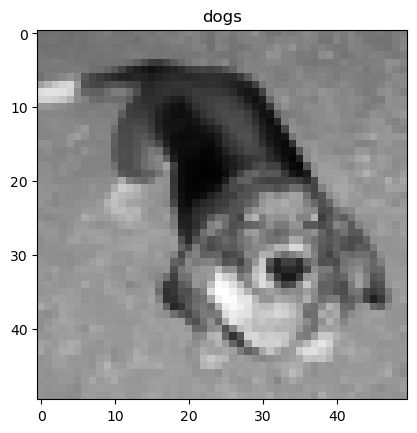

torch.Size([50, 50]) 0


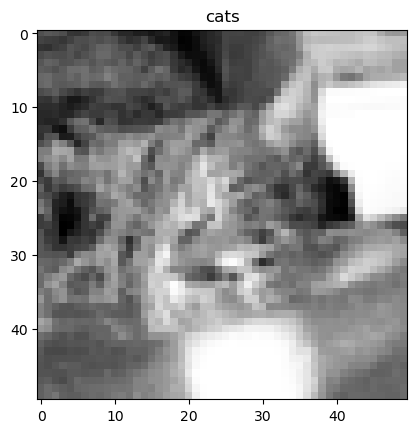

torch.Size([50, 50]) 0


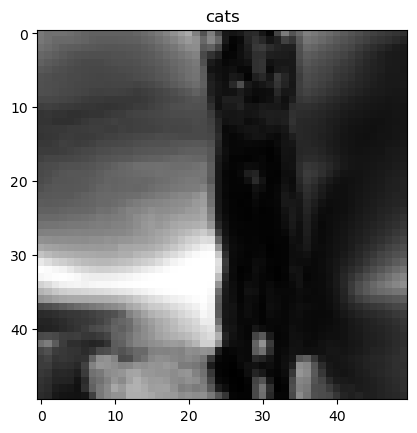

torch.Size([50, 50]) 0


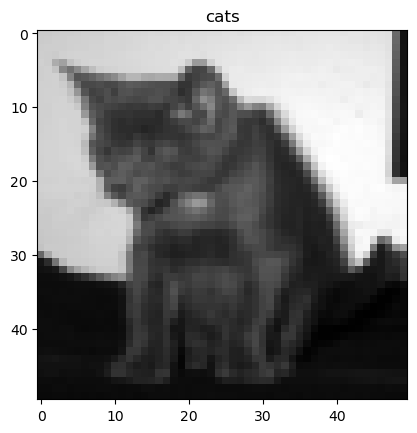

torch.Size([50, 50]) 1


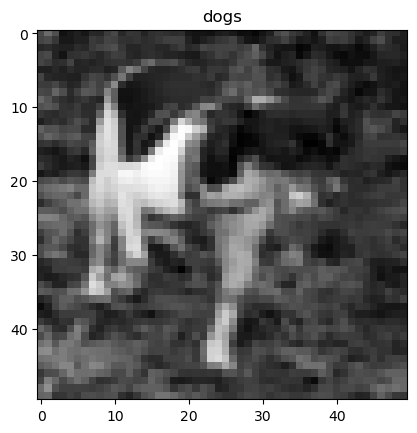

torch.Size([50, 50]) 0


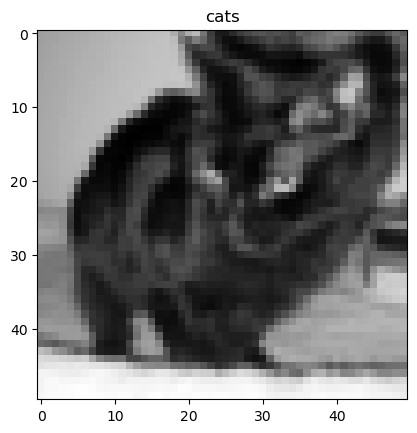

In [75]:
n = torch.randint(low=0, high=2023, size=(10,1))

for i in n:
    images, labels = test_data[i]
    print(images[0].shape, labels)
    plt.imshow(images[0], cmap='gray')
    plt.title(test_data._list_classes[labels])
    plt.show()